In [2]:
import pandas as pd

# Load the uploaded CSV file to examine its contents
file_path = '/content/traffic.csv'
traffic_data = pd.read_csv(file_path)

# Display basic information and the first few rows of the data to inspect its structure
traffic_data_info = traffic_data.info()
traffic_data_head = traffic_data.head()

traffic_data_info, traffic_data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


(None,
               DateTime  Junction  Vehicles           ID
 0  2015-11-01 00:00:00         1        15  20151101001
 1  2015-11-01 01:00:00         1        13  20151101011
 2  2015-11-01 02:00:00         1        10  20151101021
 3  2015-11-01 03:00:00         1         7  20151101031
 4  2015-11-01 04:00:00         1         9  20151101041)

Data Preprocessing and Data Exploration

In [3]:
# Convert 'DateTime' column to datetime format and check for missing values
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'], format='%Y-%m-%d %H:%M:%S')

# Checking for missing values in the dataset
missing_values = traffic_data.isnull().sum()

# Display the first few rows of the dataset after converting the DateTime column and check for missing values
traffic_data.head(), missing_values


(             DateTime  Junction  Vehicles           ID
 0 2015-11-01 00:00:00         1        15  20151101001
 1 2015-11-01 01:00:00         1        13  20151101011
 2 2015-11-01 02:00:00         1        10  20151101021
 3 2015-11-01 03:00:00         1         7  20151101031
 4 2015-11-01 04:00:00         1         9  20151101041,
 DateTime    0
 Junction    0
 Vehicles    0
 ID          0
 dtype: int64)

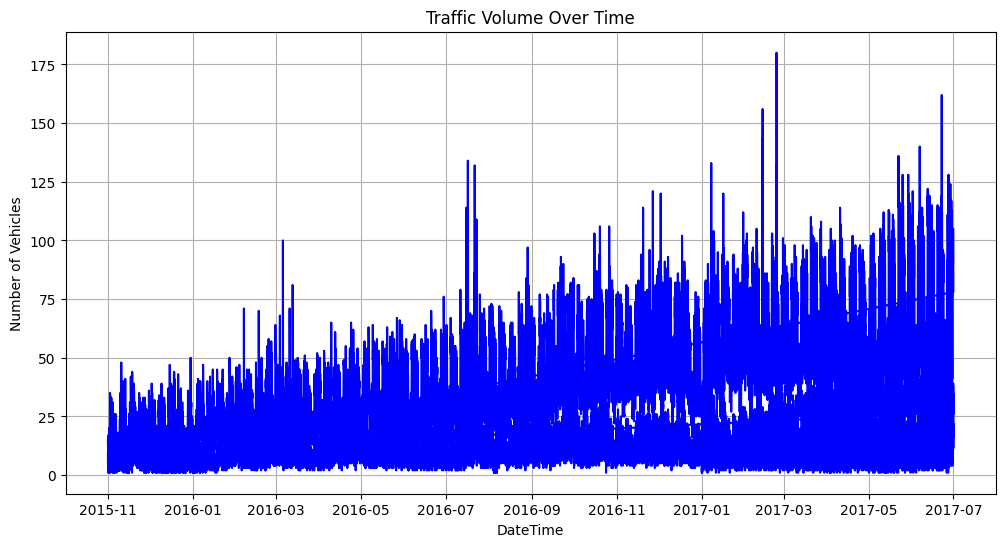

In [4]:
import matplotlib.pyplot as plt

# Plotting the traffic volume over time
plt.figure(figsize=(12, 6))
plt.plot(traffic_data['DateTime'], traffic_data['Vehicles'], label="Traffic Volume", color="blue")
plt.title('Traffic Volume Over Time')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.grid(True)
plt.show()


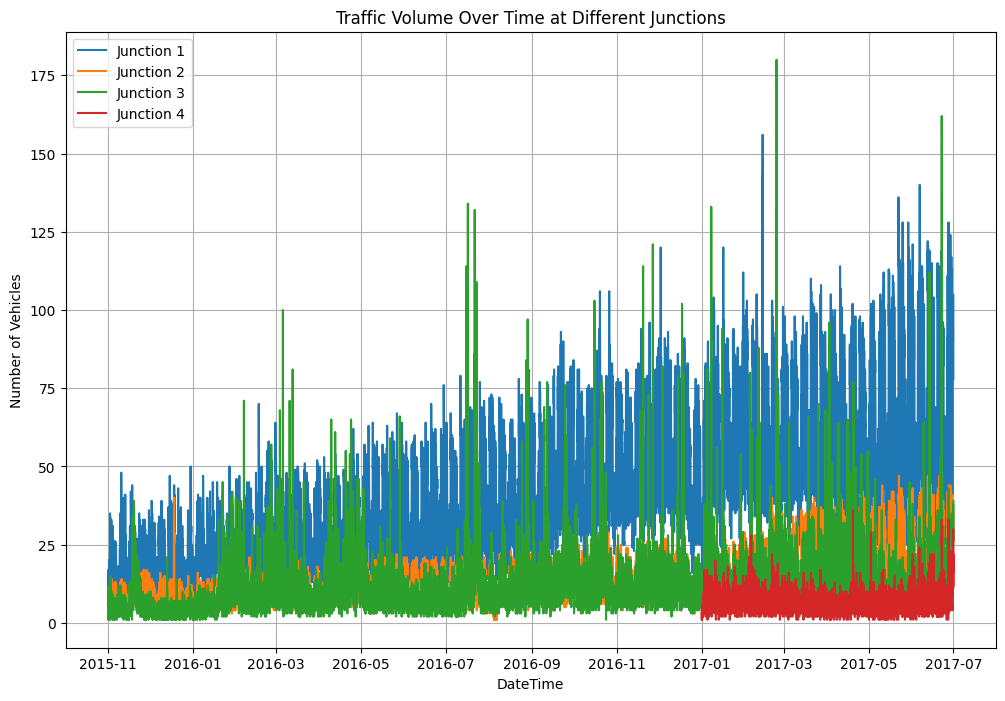

In [5]:
# Plotting traffic volume for each junction separately
plt.figure(figsize=(12, 8))

# Group the data by Junction and plot traffic volume for each junction
junctions = traffic_data['Junction'].unique()
for junction in junctions:
    junction_data = traffic_data[traffic_data['Junction'] == junction]
    plt.plot(junction_data['DateTime'], junction_data['Vehicles'], label=f'Junction {junction}')

plt.title('Traffic Volume Over Time at Different Junctions')
plt.xlabel('DateTime')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()


Feature Engineering

In [6]:
# Feature engineering: extracting temporal features from 'DateTime' column
traffic_data['Hour'] = traffic_data['DateTime'].dt.hour
traffic_data['DayOfWeek'] = traffic_data['DateTime'].dt.dayofweek
traffic_data['Month'] = traffic_data['DateTime'].dt.month
traffic_data['IsWeekend'] = traffic_data['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

# Display the first few rows of the dataset with the new features
traffic_data.head()


DateTime  Junction  Vehicles           ID  Hour  DayOfWeek  \
0 2015-11-01 00:00:00         1        15  20151101001     0          6   
1 2015-11-01 01:00:00         1        13  20151101011     1          6   
2 2015-11-01 02:00:00         1        10  20151101021     2          6   
3 2015-11-01 03:00:00         1         7  20151101031     3          6   
4 2015-11-01 04:00:00         1         9  20151101041     4          6   

   Month  IsWeekend  
0     11          1  
1     11          1  
2     11          1  
3     11          1  
4     11          1

Data Preparation

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Initialize the MinMaxScaler for scaling the 'Vehicles' column
scaler = MinMaxScaler(feature_range=(0, 1))

# Scale the 'Vehicles' column
traffic_data['Vehicles_scaled'] = scaler.fit_transform(traffic_data[['Vehicles']])

# Create sequences (sliding windows) of 24 hours (we can adjust this window size)
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]  # The next value to predict
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define the sequence length (e.g., using the past 24 hours to predict the next hour)
SEQ_LENGTH = 24

# Prepare sequences and targets for the LSTM model
vehicle_data = traffic_data['Vehicles_scaled'].values
X, y = create_sequences(vehicle_data, SEQ_LENGTH)

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Output the shapes of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((38476, 24), (9620, 24), (38476,), (9620,))

In [8]:
pip install tensorflow


Model Training

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler



# Reshape the data for LSTM (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Building the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Output model performance
print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0044 - val_loss: 9.5808e-04
Epoch 2/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 6.9588e-04 - val_loss: 8.6475e-04
Epoch 3/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 6.2055e-04 - val_loss: 8.4105e-04
Epoch 4/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 6.1439e-04 - val_loss: 8.4672e-04
Epoch 5/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 6.3954e-04 - val_loss: 8.4967e-04
Epoch 6/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 6.0403e-04 - val_loss: 8.3792e-04
Epoch 7/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 5.7706e-04 - val_loss: 8.4242e-04
Epoch 8/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 6.0832e-04 - val_loss: 7.9266e-04
Epoch 9/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 5.5179e-04 - val_loss: 8.0274e-04
Epoch 10/10
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - loss: 5.6372e-04 - val_loss: 7.9835e-04


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

None


Model Prediction

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


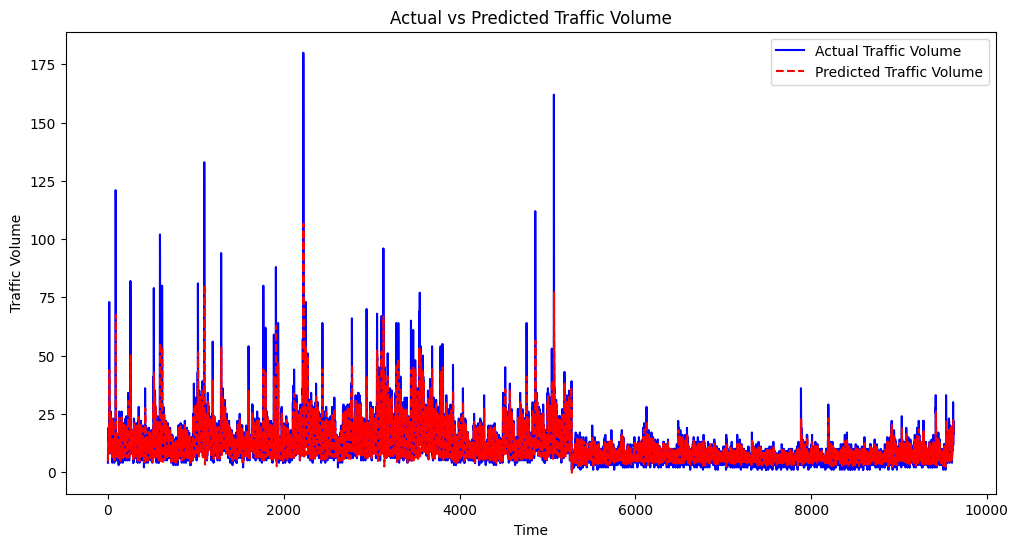

Root Mean Squared Error (RMSE): 5.057661498252163


In [10]:
import matplotlib.pyplot as plt

# Make predictions on the test set
predictions = model.predict(X_test_reshaped)

# Inverse scale the predictions and actual values back to the original scale
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results: Actual vs Predicted traffic volumes
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Traffic Volume", color="blue")
plt.plot(predictions_rescaled, label="Predicted Traffic Volume", color="red", linestyle='dashed')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

# Optional: Calculate evaluation metrics (e.g., RMSE)
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")


In [10]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Further Enhancement of the model

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1202/1202 ━━━━━━━━━━━━━━━━━━━━ 93s 74ms/step - loss: 0.0258 - val_loss: 0.0029
Epoch 2/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 89s 74ms/step - loss: 0.0047 - val_loss: 0.0024
Epoch 3/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 143s 74ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 4/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 143s 75ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 5/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 90s 75ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 6/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 94s 79ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 8/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 139s 76ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 9/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 139s 74ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/10
1202/1202 ━━━━━━━━━━━━━━━━━━━━ 142s 75ms/step - loss: 0.0017 - val_loss: 0.0017
301/301 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step


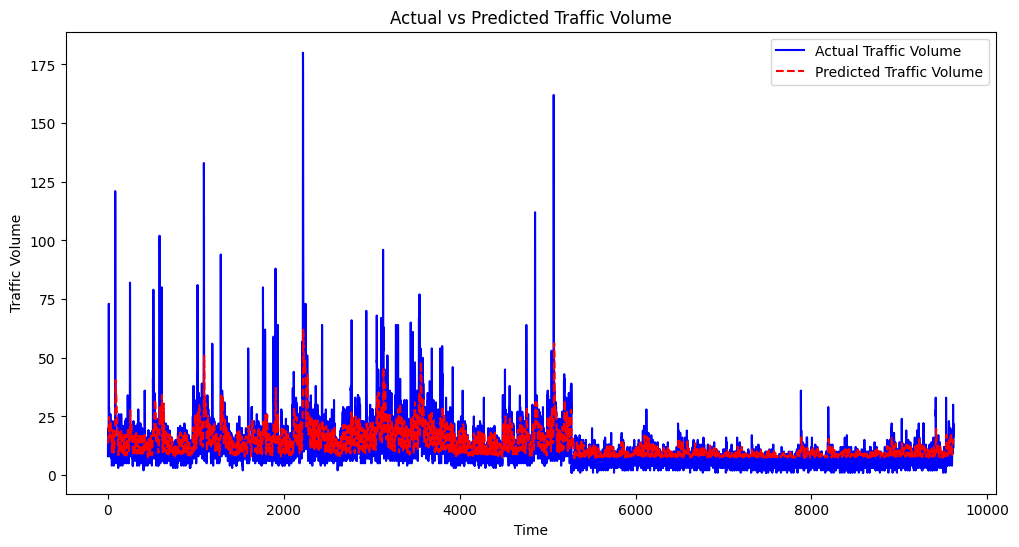

Root Mean Squared Error (RMSE): 6.935876890661386


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Adjusting the sequence length to 48 hours
SEQ_LENGTH = 48

# Recreate the sequences with 48-hour windows
X, y = create_sequences(vehicle_data, SEQ_LENGTH)

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshaping X_train and X_test to match LSTM input requirements (samples, timesteps, features)
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Building the enhanced LSTM model with stacked LSTM layers, Dropout, and L2 regularization
model = Sequential()

# First LSTM layer with L2 regularization and dropout
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, 1), kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))  # 20% dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(50, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Output layer to predict the traffic volume
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_reshaped, y_train, epochs=10, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model's performance using the same process for predictions and visualizations
predictions = model.predict(X_test_reshaped)
predictions_rescaled = scaler.inverse_transform(predictions)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting the results: Actual vs Predicted traffic volumes
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Traffic Volume", color="blue")
plt.plot(predictions_rescaled, label="Predicted Traffic Volume", color="red", linestyle='dashed')
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Further enhancement of the model

Tracking real time traffic data from OpenStreetMap Overpass API

In [15]:
import requests

# Define the Overpass API endpoint for querying traffic or road conditions
overpass_url = "http://overpass-api.de/api/interpreter"

# Overpass query to get highway information around a specific location (bounding box)
overpass_query = """
[out:json];
way["highway"](37.7749,-122.4194,37.8044,-122.2711);
out body;
"""

# Make the request to fetch traffic-related data
response = requests.post(overpass_url, data={'data': overpass_query})
osm_data = response.json()

# Print the fetched data
print(osm_data)


{'version': 0.6, 'generator': 'Overpass API 0.7.62.1 084b4234', 'osm3s': {'timestamp_osm_base': '2024-10-02T07:46:15Z', 'copyright': 'The data included in this document is from www.openstreetmap.org. The data is made available under ODbL.'}, 'elements': [{'type': 'way', 'id': 4758092, 'nodes': [30372583, 1747134008, 1747133965, 1172103532, 30373973, 1747133986, 1172103763, 1747133990, 1172103765, 1747133973, 30373974, 1747133999, 30373975], 'tags': {'bridge': 'yes', 'destination': '11th Street;14th Street', 'highway': 'motorway_link', 'junction:ref': '1A', 'lanes': '1', 'layer': '1', 'oneway': 'yes', 'sidewalk': 'no'}}, {'type': 'way', 'id': 4758138, 'nodes': [53060679, 9198751556, 667743005, 231140472, 9198751558, 9198751610, 9198751550, 9269142409, 9269142407, 9269159817, 667743012, 9269142408, 9269142403, 9269142401, 667743031, 9269142414, 30374264, 9269142404, 667743035, 9269142412, 9269142416, 9269142402, 30374265], 'tags': {'destination': '7th Street;West Grand Avenue', 'highway'

Filtering key data

In [16]:
import json

# Assuming 'osm_data' is the JSON object containing your Overpass API response
# If the data is already loaded in memory, replace this with the actual variable
# osm_data = your_json_response_variable

# Initialize lists to store the extracted data
roads = []
speed_limits = []
lanes = []
coordinates = []

# Loop through the data elements to filter key information
for element in osm_data['elements']:
    if element['type'] == 'way':
        road_info = {}

        # Extract the type of highway/road
        if 'highway' in element['tags']:
            road_info['highway'] = element['tags']['highway']

        # Extract the speed limit if available
        if 'maxspeed' in element['tags']:
            road_info['maxspeed'] = element['tags']['maxspeed']

        # Extract the number of lanes if available
        if 'lanes' in element['tags']:
            road_info['lanes'] = element['tags']['lanes']

        # Extract the coordinates (nodes) of the road
        road_coords = []
        if 'nodes' in element:
            for node in element['nodes']:
                road_coords.append(node)
            road_info['coordinates'] = road_coords

        # Store the information
        if road_info:
            roads.append(road_info)

# Output the filtered data
for road in roads:
    print(road)


Streaming output truncated to the last 5000 lines.
{'highway': 'footway', 'coordinates': [7209438672, 7209510881]}
{'highway': 'footway', 'coordinates': [7209510864, 7209510863, 7223662388, 7209510880]}
{'highway': 'footway', 'coordinates': [7209510883, 7209510862, 7209510865, 7209510864]}
{'highway': 'footway', 'coordinates': [7209438677, 7209510882]}
{'highway': 'footway', 'coordinates': [7209510866, 7209510985]}
{'highway': 'footway', 'coordinates': [7209510868, 7209510873, 7209510869]}
{'highway': 'footway', 'coordinates': [7209510870, 7209510868]}
{'highway': 'footway', 'coordinates': [7209510872, 7209510871]}
{'highway': 'footway', 'coordinates': [6925251693, 7209510874, 7209510870]}
{'highway': 'footway', 'coordinates': [6925251687, 7209510869]}
{'highway': 'footway', 'coordinates': [7209510987, 7209510879, 7209510877, 7209510878, 6925251686]}
{'highway': 'footway', 'coordinates': [7209510880, 7209510884]}
{'highway': 'footway', 'coordinates': [7209510881, 7209510866]}
{'highway

In [17]:
# Save the filtered data to a text file
with open('filtered_roads_data.txt', 'w') as outfile:
    for road in roads:
        outfile.write(f"{road}\n")

print("Filtered data saved to 'filtered_roads_data.txt'")


Filtered data saved to 'filtered_roads_data.txt'


Organizing the Filtered Data

In [19]:
import pandas as pd
import ast  # To safely evaluate the string representation of a dictionary

# Load the OSM filtered data
with open('filtered_roads_data.txt', 'r') as file:
    roads_data = file.readlines()

# Initialize lists to store relevant data
road_types = []
speed_limits = []
lane_counts = []
coordinates = []

# Extract relevant information from each road (assuming the lines are dictionary-like)
for line in roads_data:
    try:
        road = ast.literal_eval(line.strip())  # Use ast.literal_eval to parse the dictionary-like strings

        # Extract road type (highway)
        road_types.append(road.get('highway', 'Unknown'))

        # Extract speed limits (if available)
        speed_limits.append(road.get('maxspeed', 'Unknown'))

        # Extract number of lanes (if available)
        lane_counts.append(road.get('lanes', 'Unknown'))

        # Extract coordinates
        coordinates.append(road.get('coordinates', []))

    except (ValueError, SyntaxError):
        print(f"Skipping malformed line: {line}")
        continue

# Create a DataFrame to organize the extracted data
roads_df = pd.DataFrame({
    'Road Type': road_types,
    'Speed Limit': speed_limits,
    'Lanes': lane_counts,
    'Coordinates': coordinates
})

# Display the first few rows of the DataFrame to inspect the data
print(roads_df.head())

# Save the organized data to a CSV file
roads_df.to_csv('organized_osm_data.csv', index=False)
print("Data has been organized and saved to 'organized_osm_data.csv'")


       Road Type Speed Limit    Lanes  \
0  motorway_link     Unknown        1   
1  motorway_link     Unknown        2   
2  motorway_link     Unknown  Unknown   
3    residential     Unknown  Unknown   
4        service     Unknown  Unknown   

                                         Coordinates  
0  [30372583, 1747134008, 1747133965, 1172103532,...  
1  [53060679, 9198751556, 667743005, 231140472, 9...  
2         [53060708, 1172087459, 30374270, 30374271]  
3                               [33242031, 65292114]  
4                  [414546108, 5316393690, 52979813]  
Data has been organized and saved to 'organized_osm_data.csv'


In [20]:
import pandas as pd

# Load the uploaded CSV file to examine its contents
file_path = '/content/organized_osm_data.csv'
roads_df = pd.read_csv(file_path)

# Clean the 'Speed Limit' column, replace 'Unknown' with a default or NaN value
roads_df['Speed Limit'] = roads_df['Speed Limit'].replace('Unknown', pd.NA)

# Clean the 'Lanes' column, replace 'Unknown' with NaN or a default value
roads_df['Lanes'] = roads_df['Lanes'].replace('Unknown', pd.NA)

# Optionally, convert the 'Lanes' and 'Speed Limit' columns to numeric where possible
roads_df['Lanes'] = pd.to_numeric(roads_df['Lanes'], errors='coerce')
roads_df['Speed Limit'] = roads_df['Speed Limit'].str.extract('(\d+)').astype(float)

# Handle the 'Coordinates' column, converting strings to lists of coordinates
import ast
roads_df['Coordinates'] = roads_df['Coordinates'].apply(ast.literal_eval)

# Save the cleaned data to a new CSV file
roads_df.to_csv('cleaned_osm_data.csv', index=False)

# Display the cleaned data
print(roads_df.head())


       Road Type  Speed Limit  Lanes  \
0  motorway_link          NaN    1.0   
1  motorway_link          NaN    2.0   
2  motorway_link          NaN    NaN   
3    residential          NaN    NaN   
4        service          NaN    NaN   

                                         Coordinates  
0  [30372583, 1747134008, 1747133965, 1172103532,...  
1  [53060679, 9198751556, 667743005, 231140472, 9...  
2         [53060708, 1172087459, 30374270, 30374271]  
3                               [33242031, 65292114]  
4                  [414546108, 5316393690, 52979813]  


Feature Engineering

Encoding road types

In [21]:
# Encode 'Road Type' as numerical values
roads_df['Road Type Encoded'] = roads_df['Road Type'].astype('category').cat.codes

# Check the first few rows of the updated DataFrame
print(roads_df[['Road Type', 'Road Type Encoded']].head())


       Road Type  Road Type Encoded
0  motorway_link                  8
1  motorway_link                  8
2  motorway_link                  8
3    residential                 14
4        service                 17


Filling missing values

In [22]:
# Fill missing values for 'Lanes' and 'Speed Limit'
#  use the median, mode, or a fixed value based on your knowledge of the data
roads_df['Lanes'].fillna(roads_df['Lanes'].median(), inplace=True)
roads_df['Speed Limit'].fillna(roads_df['Speed Limit'].median(), inplace=True)

# Check the DataFrame to ensure missing values are filled
print(roads_df[['Speed Limit', 'Lanes']].isnull().sum())  # Should output 0 for both columns


Speed Limit    0
Lanes          0
dtype: int64


<ipython-input-22-0e00dd7fa82a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  roads_df['Lanes'].fillna(roads_df['Lanes'].median(), inplace=True)
<ipython-input-22-0e00dd7fa82a>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplac

Extracting features from coordinates

In [23]:
# Feature: Number of coordinates (as a proxy for road length)
roads_df['Num Coordinates'] = roads_df['Coordinates'].apply(len)

# Check the DataFrame
print(roads_df[['Coordinates', 'Num Coordinates']].head())


                                         Coordinates  Num Coordinates
0  [30372583, 1747134008, 1747133965, 1172103532,...               13
1  [53060679, 9198751556, 667743005, 231140472, 9...               23
2         [53060708, 1172087459, 30374270, 30374271]                4
3                               [33242031, 65292114]                2
4                  [414546108, 5316393690, 52979813]                3


Saving the enhanced data

In [24]:
# Save the enhanced dataset to a new CSV file
roads_df.to_csv('enhanced_osm_data.csv', index=False)

print("Enhanced data saved to 'enhanced_osm_data.csv'")


Enhanced data saved to 'enhanced_osm_data.csv'


In [25]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = '/content/enhanced_osm_data.csv'
osm_data = pd.read_csv(file_path)

# Display the first few rows to ensure the data is loaded correctly
print(osm_data.head())


       Road Type  Speed Limit  Lanes  \
0  motorway_link         25.0    1.0   
1  motorway_link         25.0    2.0   
2  motorway_link         25.0    3.0   
3    residential         25.0    3.0   
4        service         25.0    3.0   

                                         Coordinates  Road Type Encoded  \
0  [30372583, 1747134008, 1747133965, 1172103532,...                  8   
1  [53060679, 9198751556, 667743005, 231140472, 9...                  8   
2         [53060708, 1172087459, 30374270, 30374271]                  8   
3                               [33242031, 65292114]                 14   
4                  [414546108, 5316393690, 52979813]                 17   

   Num Coordinates  
0               13  
1               23  
2                4  
3                2  
4                3  


In [26]:
# Check for missing values in each column
missing_values = osm_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)


Missing values in each column:
Road Type            0
Speed Limit          0
Lanes                0
Coordinates          0
Road Type Encoded    0
Num Coordinates      0
dtype: int64


In [27]:
# Summary statistics for numeric columns
summary_statistics = osm_data[['Speed Limit', 'Lanes', 'Num Coordinates']].describe()
print("Summary statistics:")
print(summary_statistics)


Summary statistics:
        Speed Limit         Lanes  Num Coordinates
count  11720.000000  11720.000000     11720.000000
mean      25.177474      2.953328         4.488140
std        3.027745      0.451172         5.806052
min        5.000000      1.000000         2.000000
25%       25.000000      3.000000         2.000000
50%       25.000000      3.000000         3.000000
75%       25.000000      3.000000         5.000000
max       65.000000      7.000000       188.000000


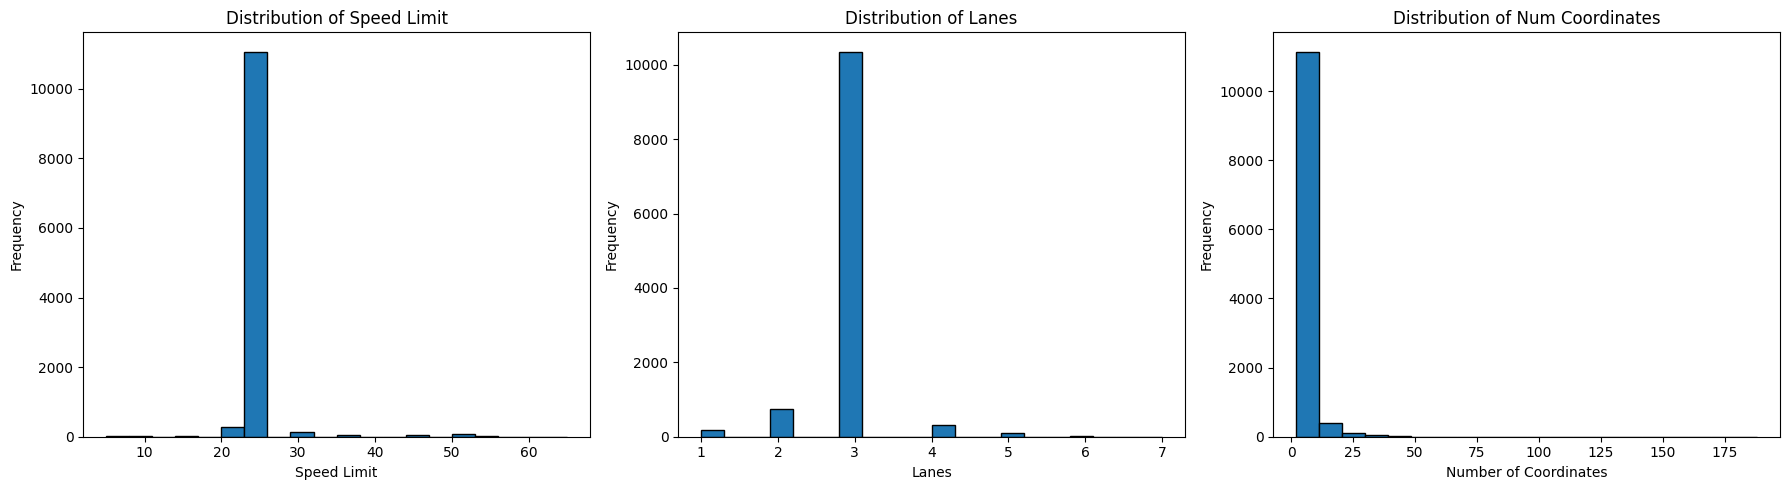

In [28]:
import matplotlib.pyplot as plt

# Plot histograms for Speed Limit, Lanes, and Num Coordinates
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Speed Limit
axes[0].hist(osm_data['Speed Limit'], bins=20, edgecolor='black')
axes[0].set_title('Distribution of Speed Limit')
axes[0].set_xlabel('Speed Limit')
axes[0].set_ylabel('Frequency')

# Lanes
axes[1].hist(osm_data['Lanes'], bins=20, edgecolor='black')
axes[1].set_title('Distribution of Lanes')
axes[1].set_xlabel('Lanes')
axes[1].set_ylabel('Frequency')

# Num Coordinates
axes[2].hist(osm_data['Num Coordinates'], bins=20, edgecolor='black')
axes[2].set_title('Distribution of Num Coordinates')
axes[2].set_xlabel('Number of Coordinates')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


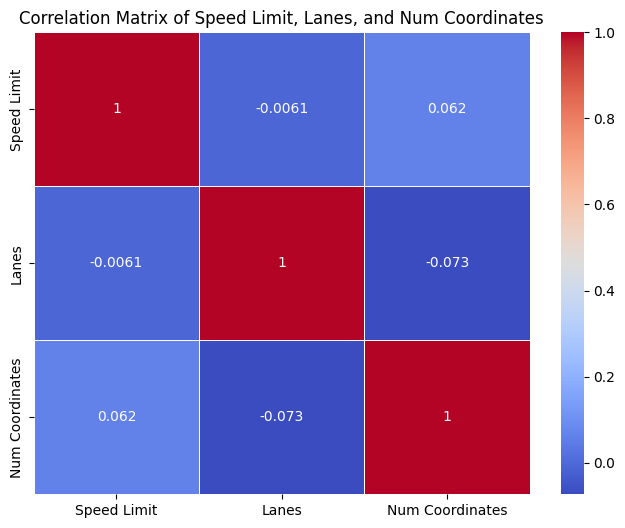

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = osm_data[['Speed Limit', 'Lanes', 'Num Coordinates']].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Speed Limit, Lanes, and Num Coordinates')
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


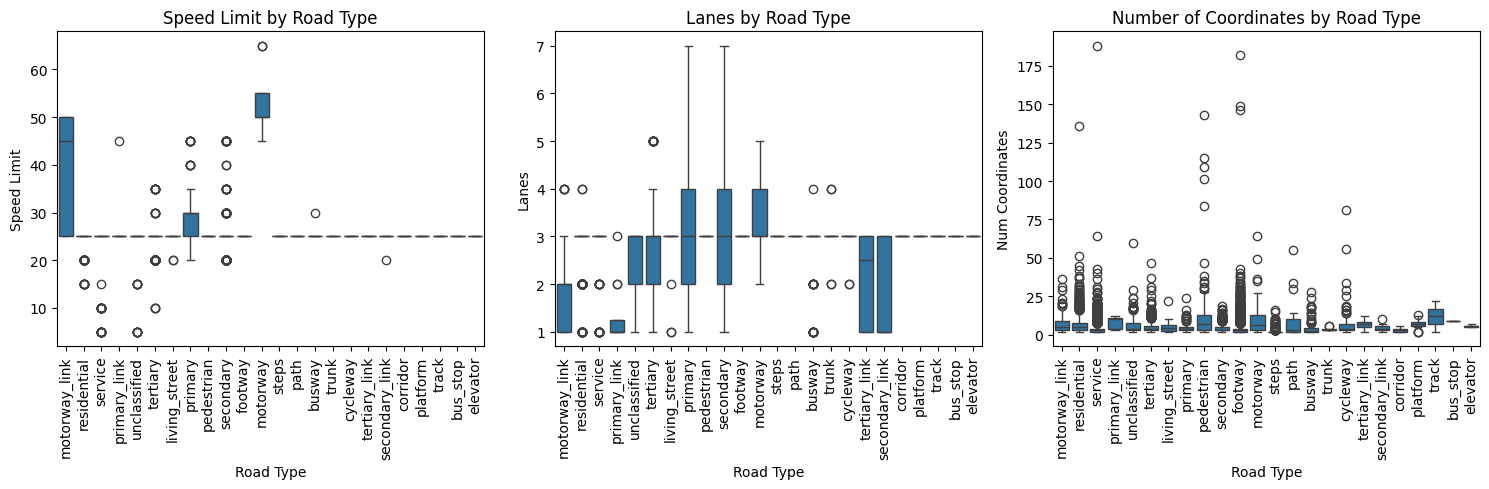

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set figure size for better visibility
plt.figure(figsize=(15, 5))

# Plot box plots for Speed Limit by Road Type
plt.subplot(1, 3, 1)
sns.boxplot(x='Road Type', y='Speed Limit', data=osm_data)
plt.xticks(rotation=90)
plt.title('Speed Limit by Road Type')

# Plot box plots for Lanes by Road Type
plt.subplot(1, 3, 2)
sns.boxplot(x='Road Type', y='Lanes', data=osm_data)
plt.xticks(rotation=90)
plt.title('Lanes by Road Type')

# Plot box plots for Num Coordinates by Road Type
plt.subplot(1, 3, 3)
sns.boxplot(x='Road Type', y='Num Coordinates', data=osm_data)
plt.xticks(rotation=90)
plt.title('Number of Coordinates by Road Type')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


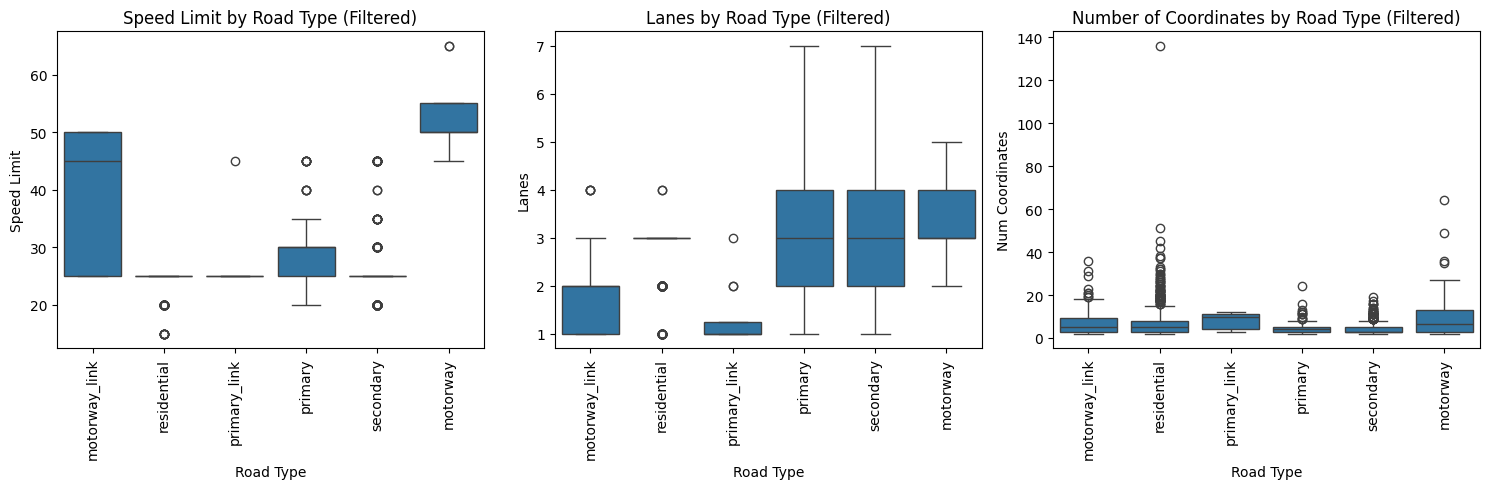

In [31]:
# Define the road types of interest
road_types_of_interest = ['motorway', 'motorway_link', 'primary', 'primary_link', 'secondary', 'residential']

# Filter the dataset
filtered_osm_data = osm_data[osm_data['Road Type'].isin(road_types_of_interest)]

# Box plot for Speed Limit by Road Type (filtered)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='Road Type', y='Speed Limit', data=filtered_osm_data)
plt.xticks(rotation=90)
plt.title('Speed Limit by Road Type (Filtered)')

# Box plot for Lanes by Road Type (filtered)
plt.subplot(1, 3, 2)
sns.boxplot(x='Road Type', y='Lanes', data=filtered_osm_data)
plt.xticks(rotation=90)
plt.title('Lanes by Road Type (Filtered)')

# Box plot for Num Coordinates by Road Type (filtered)
plt.subplot(1, 3, 3)
sns.boxplot(x='Road Type', y='Num Coordinates', data=filtered_osm_data)
plt.xticks(rotation=90)
plt.title('Number of Coordinates by Road Type (Filtered)')

plt.tight_layout()
plt.show()


<ipython-input-33-aa2016816816>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_osm_data['Cluster'] = kmeans.fit_predict(cluster_data_scaled)


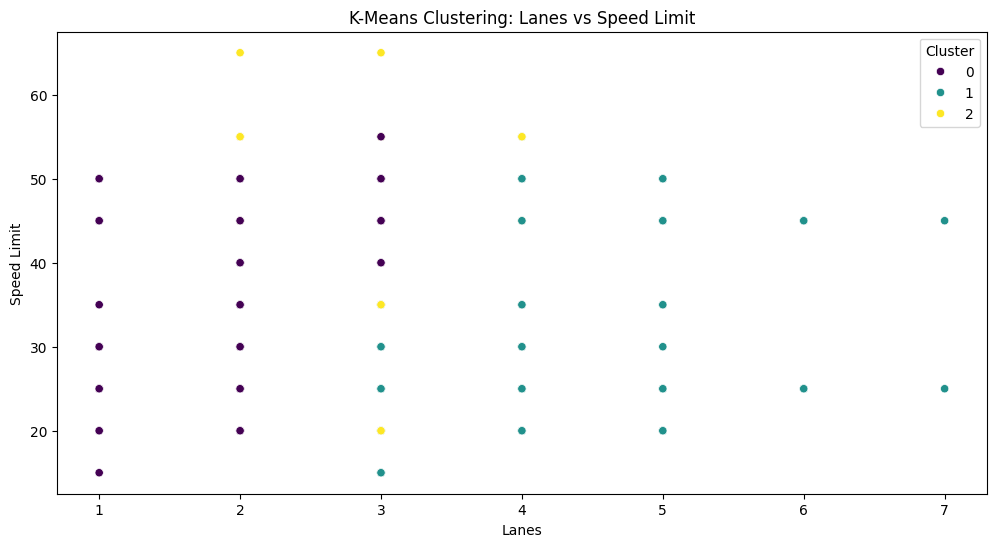

         Speed Limit     Lanes  Num Coordinates    Road Type
Cluster                                                     
0          28.205882  1.835294         4.949020    secondary
1          25.519531  3.370312         4.463281  residential
2          33.899083  2.651376        23.376147  residential


In [33]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for clustering
cluster_data = filtered_osm_data[['Speed Limit', 'Lanes', 'Num Coordinates']]

# Standardize the features
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(cluster_data)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
filtered_osm_data['Cluster'] = kmeans.fit_predict(cluster_data_scaled)

# Visualize the clustering results using the numeric columns
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Lanes', y='Speed Limit', hue='Cluster', data=filtered_osm_data, palette='viridis')
plt.title('K-Means Clustering: Lanes vs Speed Limit')
plt.show()

# Summarize the clusters
cluster_summary = filtered_osm_data.groupby('Cluster').agg({
    'Speed Limit': 'mean',
    'Lanes': 'mean',
    'Num Coordinates': 'mean',
    'Road Type': lambda x: x.mode()[0]  # Get the most frequent road type in each cluster
})

print(cluster_summary)


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


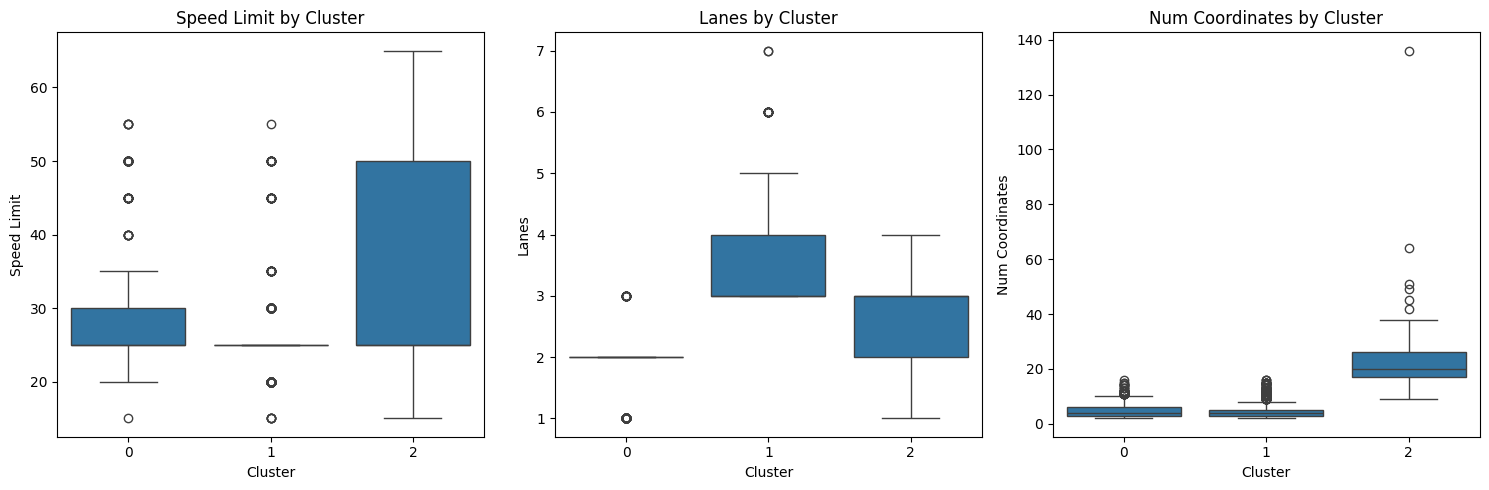

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming roads_df contains the cleaned data with cluster labels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x='Cluster', y='Speed Limit', data=filtered_osm_data, ax=axes[0])
axes[0].set_title('Speed Limit by Cluster')

sns.boxplot(x='Cluster', y='Lanes', data=filtered_osm_data, ax=axes[1])
axes[1].set_title('Lanes by Cluster')

sns.boxplot(x='Cluster', y='Num Coordinates', data=filtered_osm_data, ax=axes[2])
axes[2].set_title('Num Coordinates by Cluster')

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

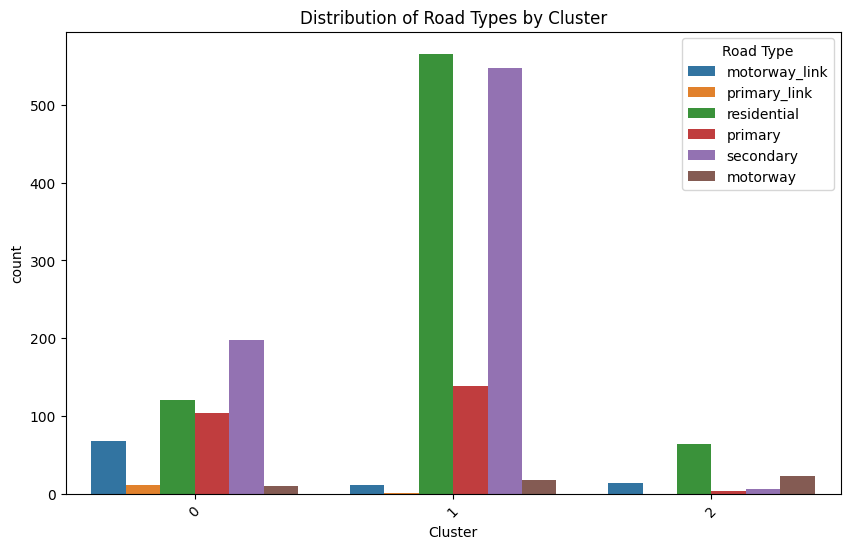

In [43]:
# Bar plot of Road Types across clusters
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='Road Type', data=filtered_osm_data)
plt.title('Distribution of Road Types by Cluster')
plt.xticks(rotation=45)
plt.show()


In [44]:
# Filter for Cluster 2 and sort by Num Coordinates
cluster_2_outliers = filtered_osm_data[filtered_osm_data['Cluster'] == 2].sort_values(by='Num Coordinates', ascending=False)

# Display top 10 rows with the highest number of coordinates
print(cluster_2_outliers[['Road Type', 'Speed Limit', 'Lanes', 'Num Coordinates']].head(10))


        Road Type  Speed Limit  Lanes  Num Coordinates
9133  residential         25.0    1.0              136
767      motorway         55.0    3.0               64
175   residential         25.0    2.0               51
770      motorway         55.0    3.0               49
1645  residential         25.0    2.0               45
845   residential         25.0    3.0               42
112   residential         25.0    3.0               38
3776  residential         25.0    2.0               37
2464  residential         25.0    3.0               37
5849     motorway         55.0    3.0               36


In [45]:
# Define a threshold for complexity, e.g., roads with more than 10 coordinates are considered complex
filtered_osm_data['Complex Road'] = filtered_osm_data['Num Coordinates'] > 10

# Display the first few rows to verify
print(filtered_osm_data[['Road Type', 'Speed Limit', 'Lanes', 'Num Coordinates', 'Complex Road']].head())


       Road Type  Speed Limit  Lanes  Num Coordinates  Complex Road
0  motorway_link         25.0    1.0               13          True
1  motorway_link         25.0    2.0               23          True
2  motorway_link         25.0    3.0                4         False
3    residential         25.0    3.0                2         False
5   primary_link         45.0    1.0               12          True


<ipython-input-45-69fe18754d1a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_osm_data['Complex Road'] = filtered_osm_data['Num Coordinates'] > 10
